In [87]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.preprocessing import MinMaxScaler

# --- Database connection details ---
DB_HOST = 'localhost'
DB_USER = 'gmaayan'
DB_PASSWORD = 'j.UyNY.3NsP6vrdfy3LNq.2f'
DB_NAME = 'tweets'

In [99]:
# --- Connect to the database ---
db_connection = mysql.connector.connect(
    host=DB_HOST,
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    charset="utf8mb4",
    collation="utf8mb4_unicode_ci"
)

# Create a cursor object
cursor = db_connection.cursor()

In [100]:
# get tweet ids
query = "SELECT id FROM tweets"
cursor.execute(query)
results = cursor.fetchall()
tweet_ids = [result[0] for result in results]
print(f'Retrieved {len(tweet_ids)} tweet ids.')

Retrieved 11934 tweet ids.


In [101]:
# get notes
placeholders = ", ".join(["%s"] * len(tweet_ids))
query = f"""SELECT 
    noteId,
    tweetId,
    classification,
    believable,
    harmful,
    misleadingOther,
    misleadingFactualError,
    misleadingManipulatedMedia,
    misleadingOutdatedInformation,
    misleadingMissingImportantContext,
    misleadingUnverifiedClaimAsFact,
    misleadingSatire,
    notMisleadingOther,
    notMisleadingFactuallyCorrect,
    notMisleadingOutdatedButNotWhenWritten,
    notMisleadingClearlySatire,
    notMisleadingPersonalOpinion
FROM notes WHERE tweetId IN ({placeholders})"""
cursor.execute(query, tweet_ids)
results = cursor.fetchall()
full_notes = pd.DataFrame(results, columns=[
    'noteId', 
    'tweetId', 
    'classification', 
    'believable', 
    'harmful', 
    'misleadingOther', 
    'misleadingFactualError', 
    'misleadingManipulatedMedia', 
    'misleadingOutdatedInformation', 
    'misleadingMissingImportantContext', 
    'misleadingUnverifiedClaimAsFact', 
    'misleadingSatire', 
    'notMisleadingOther', 
    'notMisleadingFactuallyCorrect', 
    'notMisleadingOutdatedButNotWhenWritten', 
    'notMisleadingClearlySatire', 
    'notMisleadingPersonalOpinion'
])
note_ids = [str(id) for id in list(full_notes['noteId'].unique())]
print(f'Retrieved {len(full_notes)} notes.')

Retrieved 61723 notes.


In [102]:
# get ratings for the notes
placeholders = ", ".join(["%s"] * len(note_ids))
query = f"""SELECT 
    noteId,
    raterParticipantId,
    helpfulnessLevel,
    ratedOnTweetId
FROM note_ratings WHERE noteId IN ({placeholders})"""
cursor.execute(query, note_ids)
results = cursor.fetchall()
full_ratings = pd.DataFrame(results, columns=[
    'noteId', 
    'raterParticipantId', 
    'helpfulnessLevel', 
    'ratedOnTweetId'
])
print(f'Retrieved {len(full_ratings)} ratings.')

Retrieved 29631500 ratings.


In [110]:
# get full tweets
query = f"""
SELECT 
    id,
    text,
    created_at,
    author_id,
    retweet_count,
    reply_count,
    like_count,
    quote_count,
    bookmark_count,
    impression_count,
    interaction_score,
    action_count
FROM tweets
"""
cursor.execute(query)
results = cursor.fetchall()
full_tweets = pd.DataFrame(results, columns=[
    'id', 
    'text', 
    'created_at', 
    'author_id', 
    'retweet_count', 
    'reply_count', 
    'like_count', 
    'quote_count', 
    'bookmark_count', 
    'impression_count',
    'interaction_score',
    'action_count'
])
print(f'Retrieved {len(full_tweets)} tweets.')

Retrieved 11934 tweets.


In [104]:
# calculate interaction scores and externalities


# get ratings score for the notes
ratings_map = {
    'HELPFUL': 1,
    'SOMEWHAT_HELPFUL': 0,
    'NOT_HELPFUL': -1
}

full_ratings['rating_score'] = full_ratings['helpfulnessLevel'].map(ratings_map)
note_ratings = full_ratings[['noteId', 'rating_score']].groupby('noteId').mean().reset_index()
# add note_ratings to full_notes
full_notes = full_notes.merge(note_ratings, on='noteId', how='left')

# get externality score for the notes
full_notes.loc[full_notes['misleadingManipulatedMedia'] == 1, 'misleadingManipulatedMedia'] = -3
full_notes.loc[full_notes['misleadingMissingImportantContext'] == 1, 'misleadingMissingImportantContext'] = -3

full_notes.loc[full_notes['misleadingUnverifiedClaimAsFact'] == 1, 'misleadingUnverifiedClaimAsFact'] = -2
full_notes.loc[full_notes['misleadingFactualError'] == 1, 'misleadingFactualError'] = -2

full_notes.loc[full_notes['misleadingOutdatedInformation'] == 1, 'misleadingOutdatedInformation'] = -1
full_notes.loc[full_notes['misleadingSatire'] == 1, 'misleadingSatire'] = -1
full_notes.loc[full_notes['misleadingOther'] == 1, 'misleadingOther'] = -1


full_notes.loc[full_notes['notMisleadingOutdatedButNotWhenWritten'] == 1, 'notMisleadingOutdatedButNotWhenWritten'] = 1

full_notes.loc[full_notes['notMisleadingPersonalOpinion'] == 1, 'notMisleadingPersonalOpinion'] = 2
full_notes.loc[full_notes['notMisleadingClearlySatire'] == 1, 'notMisleadingClearlySatire'] = 2
full_notes.loc[full_notes['notMisleadingOther'] == 1, 'notMisleadingOther'] = 2

full_notes.loc[full_notes['notMisleadingFactuallyCorrect'] == 1, 'notMisleadingFactuallyCorrect'] = 3

full_notes['type_min'] = full_notes[
    ['misleadingManipulatedMedia',
     'misleadingMissingImportantContext',
     'misleadingUnverifiedClaimAsFact',
     'misleadingFactualError',
     'misleadingOutdatedInformation',
     'misleadingSatire',
     'misleadingOther',
     'notMisleadingOutdatedButNotWhenWritten',
     'notMisleadingPersonalOpinion',
     'notMisleadingClearlySatire',
     'notMisleadingOther',
     'notMisleadingFactuallyCorrect']].min(axis=1)
full_notes['externality'] = full_notes['type_min'] - full_notes['rating_score']

In [111]:
# add externality scores to tweets
notes_score_by_tweet = full_notes[['tweetId', 'externality']].groupby('tweetId').mean().reset_index()
full_tweets = full_tweets.merge(notes_score_by_tweet, left_on='id', right_on='tweetId', how='left')

# filter out tweets with no impressions
full_tweets = full_tweets[full_tweets['impression_count'] > 0]

# add action count per 1000 impressions
full_tweets['action_count_per_1000_impressions'] = full_tweets['action_count'] / (full_tweets['impression_count'] / 1000)

# remove outlier with massive action count 
# Alina Habba tweetid: 1819110904216084953
# Drug free world tweetid: 1847181579103490414
full_tweets = full_tweets[full_tweets['action_count_per_1000_impressions'] < 150]

print(full_tweets[['interaction_score','externality', 'action_count']].describe())

       interaction_score   externality  action_count
count       1.185300e+04  11853.000000  1.185300e+04
mean        7.261223e-03     -2.078199  7.378737e+04
std         8.994813e-03      1.078058  1.593500e+05
min         4.500000e-07     -3.998000  5.000000e+00
25%         1.650212e-03     -2.932458  5.880000e+03
50%         4.360297e-03     -1.861600  2.032700e+04
75%         9.392109e-03     -1.192453  7.139900e+04
max         1.254045e-01      0.460186  5.446737e+06


In [112]:
# scale scores
# rescale externality to be between -1 and 1 while preserving the sign
externality = full_tweets['externality']
min_val, max_val = externality.min(), externality.max()
full_tweets['externality_scaled'] = -1 + (externality-min_val) * (1-(-1)) / (max_val-min_val)

# rescale interaction score to be between 0 and 1
interaction_score = full_tweets['interaction_score']
min_val, max_val = interaction_score.min(), interaction_score.max()
full_tweets['interaction_score_scaled'] = (interaction_score-min_val) * (1-0) / (max_val-min_val)

# rescale action count to be between 0 and 1
action_count = full_tweets['action_count']
min_val, max_val = action_count.min(), action_count.max()
full_tweets['action_count_scaled'] = (action_count-min_val) * (1-0) / (max_val-min_val)

# get externality in dollars
# convert greatest externality magnitude to 1 and then multiply by 1.53 dollars per 1000 impressions (CPM)
# from the goldstein 2014 paper, the cost of bad ads was $1.53 CPM
externality = full_tweets['externality']
greatest_magnitude = abs(externality.min())
full_tweets['externality_cpm'] = (externality/greatest_magnitude) * 1.53

print(full_tweets[['interaction_score_scaled','externality_scaled', 'action_count_scaled']].describe())

       interaction_score_scaled  externality_scaled  action_count_scaled
count              11853.000000        11853.000000         11853.000000
mean                   0.057899           -0.138753             0.013546
std                    0.071727            0.483631             0.029256
min                    0.000000           -1.000000             0.000000
25%                    0.013156           -0.521984             0.001079
50%                    0.034766           -0.041583             0.003731
75%                    0.074891            0.258605             0.013108
max                    1.000000            1.000000             1.000000


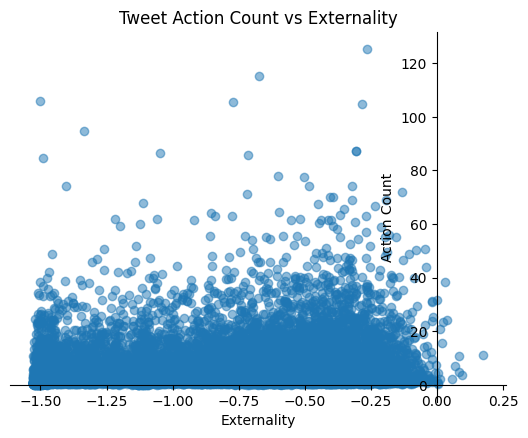

In [113]:
# plot scaled interactions vs externality

fig, ax = plt.subplots()

ax.scatter(full_tweets['externality_cpm'], full_tweets['action_count_per_1000_impressions'], alpha=0.5)
ax.set_xlabel('Externality')
ax.set_ylabel('Action Count')
ax.set_title('Tweet Action Count vs Externality')

# Move the left spine (which is normally at x=min) to x=0
ax.spines['left'].set_position('zero')
# Hide the right spine
ax.spines['right'].set_color('none')

# If you also want the x-axis drawn at y=0, do likewise:
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

# Set tick positions so they show on the moved spines
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.show()

In [114]:
# --- Clean up ---
full_tweets.to_csv('full_tweets.csv', index=False)
cursor.close()
db_connection.close()